In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
Base_Dir = '/kaggle/input/flickr8k'
Working_Dir = '/kaggle/working'

## EXTRACT IMAGE FEATURES

In [3]:
#load resnet50 model
model_resnet= ResNet50()
#restructuring the model since we don't need the last predicition layer(softmax layer)
model_resnet = Model(inputs = model_resnet.inputs, outputs = model_resnet.layers[-2].output)
#summarize
model_resnet.summary()


102967424/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [4]:
model_resnet.save_weights('model_resnet_weights.h5')

In [4]:
#extract features from image
features = {}
directory = os.path.join(Base_Dir,'Images')

for img_name in tqdm(os.listdir(directory)):
    
    #load image from the file
    img_path = directory + '/' + img_name
    image = load_img(img_path,target_size=(224,224))
    
    #convert image pixel into numpy array
    image = img_to_array(image)
    
    # reshape the data for model to exact features
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    #preprocess the image for resnet50
    image = preprocess_input(image)
    
    #extracting features
    feature = model_resnet.predict(image,verbose=0)
    
    #get the image id
    image_id = img_name.split('.')[0]
    
    # store the feature in the dictionary
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
#storing features in pickle
# this will save us re-running the above cell every time we start a new session
pickle.dump(features, open(os.path.join(Working_Dir, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
# the features computed aboove are now stored in /kaggle/input/features/features.pkl , so we need to load the features before going further
with open(os.path.join(Working_Dir, 'features.pkl') ,'rb') as f:
    features = pickle.load(f)

## LOAD THE CAPTION DATA

In [7]:
with open(os.path.join(Base_Dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
#creating mapping from image to caption 
mapping={}

# preprocessing the lines
for line in tqdm(captions_doc.split('\n')):
    #split the lines by comma
    tokens = line.split(',')
    if len(line) <2:
        continue
        
    image_id,captions = tokens[0],tokens[1:]
    # removing extension from image_ids
    image_id = image_id.split('.')[0]
    #convert caption list into string 
    captions = " ".join(captions)
    #since every image has around 5 captions , so we will store them in a list
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(captions)
    
    
    
    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
# preprocess the captions
def clean_cap(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #taking one caption at a time
            caption = captions[i]
            #preprocessing the captions
            #convert to lower case
            caption = caption.lower()
            #delete digits, special chars, etc.
            caption = caption.replace('[^A_Za-z]', '')
            #delete additonal spaces
            caption = caption.replace('\s+',' ')
            # add start and end tags to the caption and removing words with length 1
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
            

In [11]:
#before preprocess of captions
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [12]:
#after preprocessing of captions
clean_cap(mapping)
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [13]:
all_captions =[]
for key in mapping:
    for captions in mapping[key]:
        all_captions.append(captions)

In [14]:
len(all_captions)

40455

In [15]:
# Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available 
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## TRAIN TEST SPLIT

In [18]:
image_id = list(mapping.keys())
split = int(len(image_id )*0.86)
train = image_id[:split]
test = image_id[split:]

In [19]:
len(test)

1133

In [20]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## MODEL CREATION

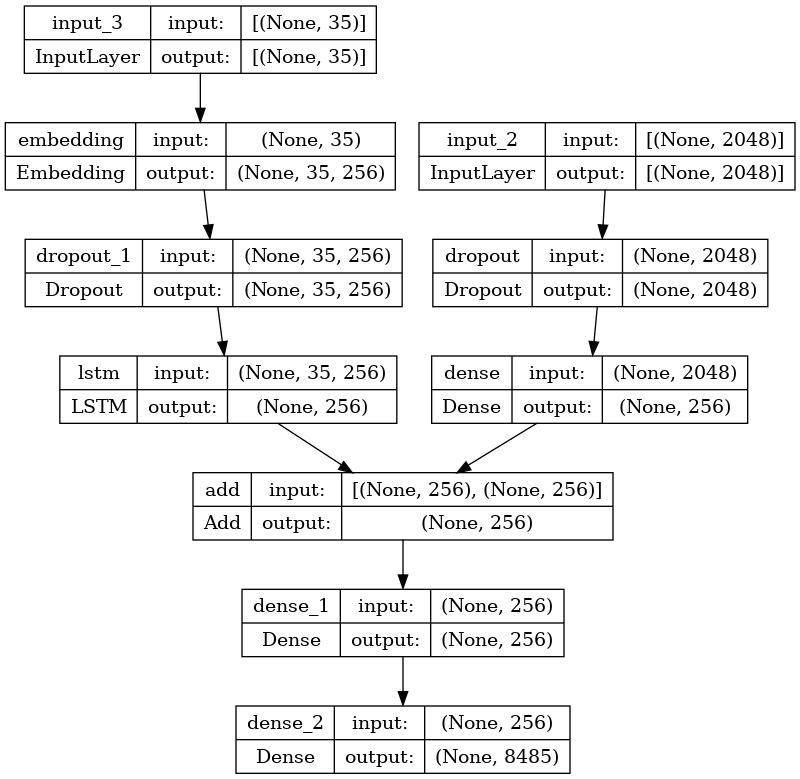

In [22]:
## encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

models = Model(inputs=[inputs1, inputs2], outputs=outputs)
models.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(models, show_shapes=True)



In [23]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    models.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

217/217 [==============================] - 74s 342ms/step - loss: 2.2248


## Saving Model and Tokenizer

In [24]:
# save the model
models.save('/kaggle/working/models.h5')

In [40]:
#save model weights
models.save_weights('mine_model_weights.h5')

In [42]:
filename = 'model_resnet.sav'
pickle.dump(model_resnet, open(filename, 'wb'))

In [44]:
# loading the saved model
loaded_model_resnet = pickle.load(open('model_resnet.sav', 'rb'))

In [48]:
filenames = 'models.sav'
pickle.dump(models, open(filenames, 'wb'))
# loading the saved model
loaded_model = pickle.load(open('models.sav', 'rb'))

In [25]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
# loading the saved model
loaded_pickle = pickle.load(open('tokenizer.pickle', 'rb'))

## Generate Captions For The Image

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

## Evaluating The Results

In [39]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(models, features[key], tokenizer, 35) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/20 [00:00<?, ?it/s]

BLEU-1: 0.585253
BLEU-2: 0.385411


## Visualize The Results

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_Dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(models, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq
--------------------Predicted--------------------
startseq black dog is jumping over log in the woods endseq


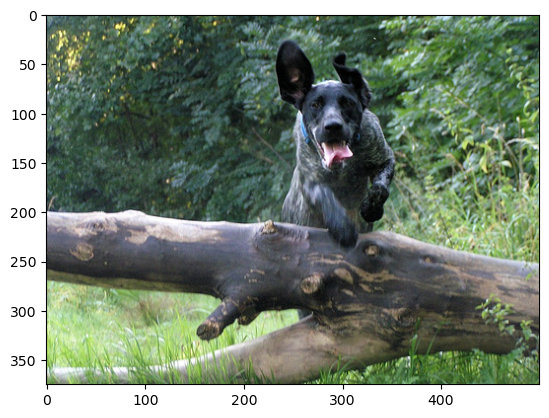

In [32]:
generate_caption("1015584366_dfcec3c85a.jpg")

---------------------Actual---------------------
startseq two different breeds of brown and white dogs play on the beach endseq
startseq two dogs are making turn on soft sand beach endseq
startseq two dogs playing in the sand at the beach endseq
startseq two dogs playing together on beach endseq
startseq two large tan dogs play along sandy beach endseq
--------------------Predicted--------------------
startseq two dogs are playing in the sand endseq


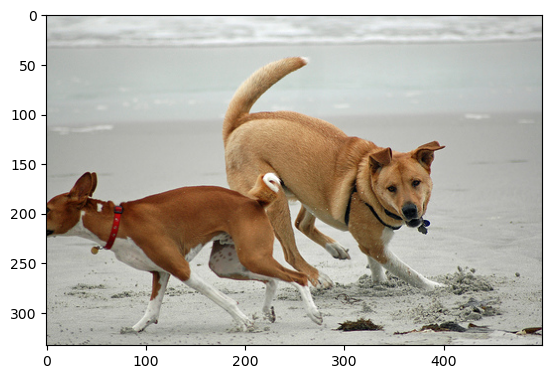

In [33]:
generate_caption("1024138940_f1fefbdce1.jpg")

---------------------Actual---------------------
startseq "a couple and an infant being held by the male sitting next to pond with near by stroller ." endseq
startseq couple sit on the grass with baby and stroller endseq
startseq couple with their newborn baby sitting under tree facing lake endseq
startseq man and woman care for an infant along the side of body of water endseq
startseq couple with baby sit outdoors next to their stroller endseq
--------------------Predicted--------------------
startseq two women are sitting on the street and look at the camera endseq


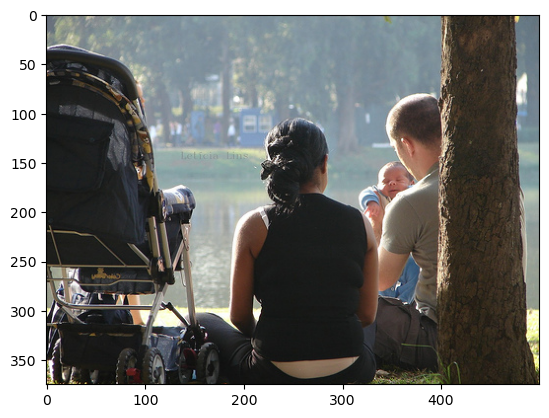

In [34]:
generate_caption("1022454428_b6b660a67b.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq little girl in pool is sliding down slide endseq


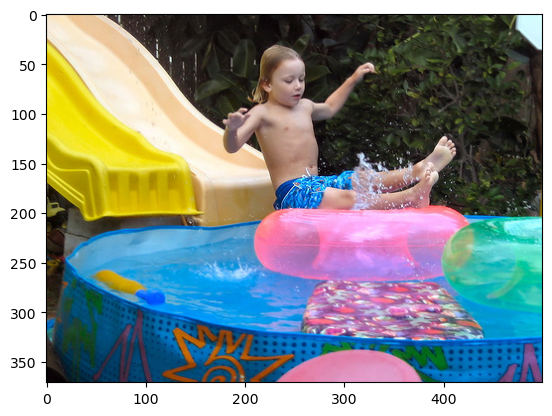

In [35]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq person on snowmobile in mid jump endseq
startseq snowmobiler flies through the air endseq
startseq snowmobile rider flies through the air on his or her machine in front of tall pine trees endseq
startseq rider jumps snowmobile high in rural area endseq
startseq the man is up in the air endseq
--------------------Predicted--------------------
startseq snowmobile rider flies through the air endseq


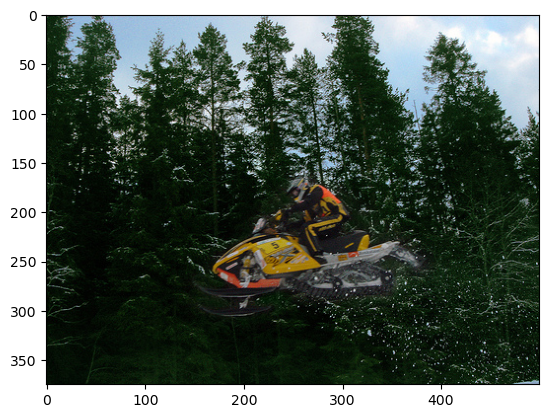

In [36]:
generate_caption("109738763_90541ef30d.jpg")

## Prediction on Real Images

In [50]:
image_path = "/kaggle/input/flickr8k/Images/101654506_8eb26cfb60.jpg" #path of your image
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = loaded_model_resnet.predict(image, verbose=0)
# predict from the trained model
predict_caption(loaded_model, feature, loaded_pickle, 35)

'startseq dog runs through the snow endseq'